In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from pyod.models.auto_encoder import AutoEncoder
from tensorflow import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('creditcard.csv')

The dataset only contains numerical variables which have been provided to us post-PCA transformation. To maintain confidentiality, original features and data cannot be provided to us. Only two features have not been transformed via PCA. 'Time' is the amount of time that has elapsed between each transaction and the first transaction in the dataset. 'Amount' represents the transaction amount. 

Can an unsupervised algorithm (ie. isolation forest) detect the 492 fradulent transactions in the dataset? Labeled datasets are costly to produce ($, manpower, etc) and difficult to find. Let's see if an unsupervised algorithm can achieve similar results.

Text(1.2, 100000, '492')

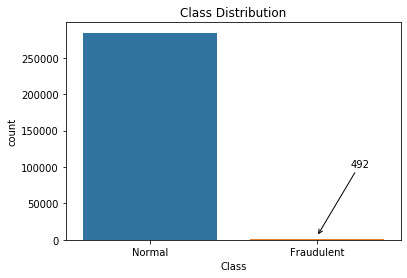

In [3]:
bars = ('Normal', 'Fraudulent')
y_pos = np.arange(2)

sns.countplot('Class', data=dataset)
plt.title('Class Distribution')
plt.xticks(y_pos, bars, horizontalalignment='center')
plt.annotate('492', xy=(1,5000), xytext=(1.2, 100000), arrowprops=dict(arrowstyle="->"))

In [4]:
print('Normal: {:.3f}%'.format(dataset['Class'].value_counts()[0]/len(dataset)*100))
print('Fradulent: {:.3f}%'.format(dataset['Class'].value_counts()[1]/len(dataset)*100))

Normal: 99.827%
Fradulent: 0.173%


## Creating our input vector (No feature engineering yet)

In [5]:
x = []
X = []
i = 0
while i < len(dataset):
    x = []
    x.append(dataset['V1'][i])
    x.append(dataset['V2'][i])
    x.append(dataset['V3'][i])
    x.append(dataset['V4'][i])
    x.append(dataset['V5'][i])
    x.append(dataset['V6'][i])
    x.append(dataset['V7'][i])
    x.append(dataset['V8'][i])
    x.append(dataset['V9'][i])
    x.append(dataset['V10'][i])
    x.append(dataset['V11'][i])
    x.append(dataset['V12'][i])
    x.append(dataset['V13'][i])
    x.append(dataset['V14'][i])
    x.append(dataset['V15'][i])
    x.append(dataset['V16'][i])
    x.append(dataset['V17'][i])
    x.append(dataset['V18'][i])
    x.append(dataset['V19'][i])
    x.append(dataset['V20'][i])
    x.append(dataset['V21'][i])
    x.append(dataset['V22'][i])
    x.append(dataset['V23'][i])
    x.append(dataset['V24'][i])
    x.append(dataset['V25'][i])
    x.append(dataset['V26'][i])
    x.append(dataset['V27'][i])
    x.append(dataset['V28'][i])
    x.append(dataset['Amount'][i])
    X.append(x)
    i += 1
    
y = dataset['Class']

What does a single input vector look like?

In [6]:
X[0]

[-1.3598071336738,
 -0.0727811733098497,
 2.53634673796914,
 1.37815522427443,
 -0.33832076994251803,
 0.462387777762292,
 0.239598554061257,
 0.0986979012610507,
 0.363786969611213,
 0.0907941719789316,
 -0.551599533260813,
 -0.617800855762348,
 -0.991389847235408,
 -0.31116935369987897,
 1.46817697209427,
 -0.47040052525947795,
 0.20797124192924202,
 0.0257905801985591,
 0.403992960255733,
 0.251412098239705,
 -0.018306777944153,
 0.277837575558899,
 -0.110473910188767,
 0.0669280749146731,
 0.12853935827352803,
 -0.189114843888824,
 0.13355837674038698,
 -0.0210530534538215,
 149.62]

## Isolation Forest

The isolation forest model is an unsupervised model which isolates anomalous points using the structure of a decision tree. The isolation forest takes advantage of 2 major properties of anomalies. 1) Anomalies are the minority class and 2) They lie further away from the ‘normal’ points in feature space. The algorithm randomly partitions the data to isolate a specific instance in the dataset. So how does this simple procedure detect anomalous points? 
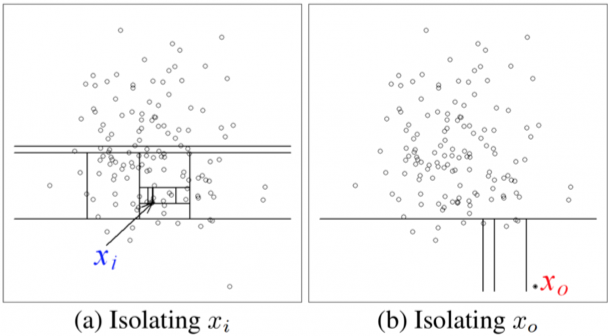






A normal point shown in (a) requires 11 random partitions to be isolated. An anomalous point shown in (b) requires 4 random partitions to be isolated. Picture from 'Isolation Forest' by Zhou et al. 


This concept can be applied to a tree structure where each partition represents a split. More splitting means the instance will be found towards the leaf nodes. Less splitting means the instance will be found towards the root node. In other words, the average location of anomalous points in each tree is closer to the root node, while the average location of normal points in each tree is closer to the leaf nodes.

In [25]:
clf = IsolationForest(behaviour='new', n_estimators=1000, contamination=.1, bootstrap=False, n_jobs=-1)
clf.fit(X)
y_pred = clf.predict(X)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Convert labels from -1, 1, to 1, 0. (1=anomalous, 0='normal')

In [26]:
labels = []
for i in y_pred:
    if i == 1:
        i = 0
    if i == -1:
        i = 1
    labels.append(i)

Adding the list of isoForest labels to our original dataframe

In [27]:
dataset['isoForest_labels'] = labels
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,isoForest_labels,autoencoder_labels
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


How many anomalies did our isoForest detect?

In [41]:
isodata_counts = dataset['isoForest_labels'].value_counts()
isodata_counts

0    256326
1     28481
Name: isoForest_labels, dtype: int64

In [29]:
print('Our unsupervised method detected ' + str(isodata_counts[1]) + ' anomalies compared to the actual number of 492.') 

Our unsupervised method detected 28481 anomalies compared to the actual number of 492.


Text(1.2, 100000, '28481')

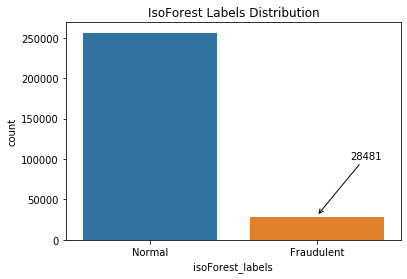

In [40]:
bars = ('Normal', 'Fraudulent')
y_pos = np.arange(2)

sns.countplot('isoForest_labels', data=dataset)
plt.title('IsoForest Labels Distribution')
plt.xticks(y_pos, bars, horizontalalignment='center')
plt.annotate(str(isodata_counts[1]), xy=(1,30000), xytext=(1.2, 100000), arrowprops=dict(arrowstyle="->"))

Are the actual anomalies (as labeled in our original dataset) even detected with the isoForest? Let's check by isolating only the fradulent instances. 

In [31]:
fraud_data = dataset[dataset['Class'] == 1].reset_index()
iso_forest_counts = fraud_data['isoForest_labels'].value_counts()
iso_forest_counts

1    439
0     53
Name: isoForest_labels, dtype: int64

In [32]:
fraud_data.head()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V23,V24,V25,V26,V27,V28,Amount,Class,isoForest_labels,autoencoder_labels
0,541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,1,1
1,623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,1,1
2,4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,1,1
3,6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,...,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,1,1
4,6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,1,1


In [51]:
print('The isolation forest correctly identified ' + str(iso_forest_counts[1]) + ' fradulent transactions.')
print('Unfortunately, it incorrectly classified ' + str(iso_forest_counts[0]) + ' fradulent transactions as normal.')
print('Furthermore, the model incorrectly identified ' + str(isodata_counts[1] - 492) + ' normal transactions as fraudulent.')

The isolation forest correctly identified 439 fradulent transactions.
Unfortunately, it incorrectly classified 53 fradulent transactions as normal.
Furthermore, the model incorrectly identified 27989 normal transactions as fraudulent.


For now it seems like the resources saved labeling the original dataset would be spent investigating the large number of false positives our isolation forest generated.

Overall, it's not advisable to have such a large dataset when using an isolation forest. Two issues arise when the dataset is too large. 
First, swamping occurs. Swamping happens when 'normal' instances encroach the feature space of the anomalous points. Too large a dataset will inevitably have points which encroach the anomalies' feature space. Secondly, masking occurs. Masking happens when too many anomalous points are present in the dataset and begin to 'mask' each other's presence. The sklearn implementation of the isoforest sets the cap of samples given to each tree within the forest at 256 to mitigate these two issues for us.  

## Other Issues
Isoforest is essentially detecting anomalous instances based on where they are in n dimensional 'feature space.' Credit card activity from a huge pool of users does not lend itself to this kind of algorithm because credit card activity between users is extremely diverse. This dataset could include personal cards, business cards, and travel cards, which all show different activity. A per-user isolation forest model would be much more effective because it would cater to the individual's card behavior. If this is too computationally expensive, models could be created for specific sub-groups. For example, different models for personal cards, business cards, and travel cards or models for users with specific credit limits could allow an isoforest to more effectively detect anomalies.   

## Autoencoder
A special type of neural network that copies the input and sets it as the network's desired output. An autoencoder can be broken down into two major steps. First, decoding occurs. Think of this as the neural network learning a simple representation of the data. More specifically, the decoding step mirros a dimensionality reduction step. The input is being compressed into easy to understand values. Second, the algorithm works to encode the simple data. In other words, we are now building our compressed values back up to recreate our input. Like with all neural networks, a loss function is calculated. This can be thought of as a reconstruction error which represents how effectively our network reproduced what we fed into it. Outliers will have greater reconstruction errors on average. Why? Intuitively, we know that outliers are 1) rare and 2) they are different. Because they are rare, the neural network is learning patterns from our 'normal' data and this is reflected in where the weights and biases of the neural network are set. In other words, the neural network has been trained to recreate 'normal' instances because those are the instances it saw most often. An outlier will exhibit different patterns and will not be recreated as effectively by the neural network, resulting in a greater reconstruction error. How anomalous an instance is, is directly related to the reconstruction error. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [17]:
clf_ae = AutoEncoder(hidden_neurons=[29, 21, 16, 12, 16, 21, 29], hidden_activation='relu', 
                     output_activation='sigmoid', loss=keras.losses.binary_crossentropy, 
                     epochs=10, contamination=.1)
trained_ae = clf_ae.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_2 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_3 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 21)               

Now that we've trained our autoencoder let's use the predict method to see which instances are anomalous.

In [18]:
ae_anomaly_labels = trained_ae.predict(X)
ae_anomaly_labels

array([0, 0, 1, ..., 0, 0, 0])

Let's throw these onto our original dataset so we can compare our classifiers. 

In [19]:
dataset['autoencoder_labels'] = ae_anomaly_labels
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,isoForest_labels,autoencoder_labels
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


In [44]:
autoencoder_counts = dataset['autoencoder_labels'].value_counts()
autoencoder_counts

0    256270
1     28537
Name: autoencoder_labels, dtype: int64

Text(1.2, 100000, '28537')

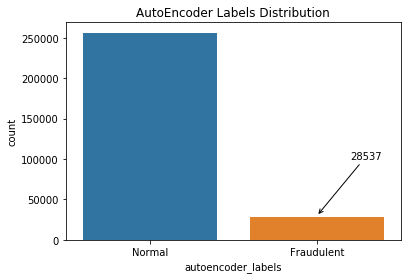

In [45]:
bars = ('Normal', 'Fraudulent')
y_pos = np.arange(2)

sns.countplot('autoencoder_labels', data=dataset)
plt.title('AutoEncoder Labels Distribution')
plt.xticks(y_pos, bars, horizontalalignment='center')
plt.annotate(str(autoencoder_counts[1]), xy=(1,30000), xytext=(1.2, 100000), arrowprops=dict(arrowstyle="->"))

In [46]:
auto_encoder_fraud_counts = fraud_data['autoencoder_labels'].value_counts()
auto_encoder_fraud_counts

1    445
0     47
Name: autoencoder_labels, dtype: int64

In [49]:
print('The autoencoder correctly identified ' + str(auto_encoder_fraud_counts[1]) + ' fradulent transactions.')
print('Unfortunately, it incorrectly classified ' + str(auto_encoder_fraud_counts[0]) + ' fradulent transactions as normal.')
print('Furthermore, the model incorrectly identified ' + str(autoencoder_counts[1] - 492) + ' normal transactions as fraudulent.')

The autoencoder correctly identified 445 fradulent transactions.
Unfortunately, it incorrectly classified 47 fradulent transactions as normal.
Furthermore, the model incorrectly identified 28045 normal transactions as fraudulent.
